In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import shapely.geometry as sg

import matplotlib.pyplot as plt
import cartopy.geodesic as geo
from cartopy.util import add_cyclic_point

In [8]:
import geopandas as gpd
sea_routes = gpd.read_file('Sea Routes.geojson')
sea_routes = sea_routes.drop(columns=['Id','OBJECTID'])
sea_routes['numbers'] = [1,2,3]
sea_routes

,Name,Shape_Leng,geometry,numbers
0,Northwest Passage,7689.630315,"LINESTRING (-168.83320 59.34944, -167.33377 62...",1
1,Northern Sea Route,7576.681873,"MULTILINESTRING ((180.00000 70.32357, 179.0842...",2
2,Transpolar,7137.175384,"LINESTRING (-169.78554 60.27749, -168.41041 62...",3


In [9]:
nsr_data = xr.open_dataset('nsr_data.nc', decode_times=True)
nsr_data = nsr_data.where(nsr_data.time.dt.month.isin(9), drop=True)
nsr_data
# only want September data for each year

<xarray.Dataset>
Dimensions:  (time: 43, lat: 96, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1982-09-01 ... 2023-09-01
  * lat      (lat) float32 66.12 66.38 66.62 66.88 ... 89.12 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
    region   int32 2
Data variables:
    icec     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [10]:
nwp_data = xr.open_dataset('nwp_data.nc', decode_times=True)
nwp_data = nwp_data.where(nwp_data.time.dt.month.isin(9), drop=True)
nwp_data
# only want September data for each year

<xarray.Dataset>
Dimensions:  (time: 43, lat: 96, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1982-09-01 ... 2023-09-01
  * lat      (lat) float32 66.12 66.38 66.62 66.88 ... 89.12 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
    region   int32 1
Data variables:
    icec     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [11]:
def route_length(geometry):

    ellipsoid = geo.Geodesic() #defaults to WGS84 radius/flattening values
    
    route = geometry
    length = ellipsoid.geometry_length(route)/1000

    return length

In [16]:
def perc_cover(dataset, route_length):
### Calculate percent ice cover of linear sea route during September of each year ###

    perc_cover = []

    for i in range(len(dataset['time'])): 
    
        data = dataset.isel(time=i)
        data = data.where(data['icec']>0.15, drop=True)

        condition = data['icec'].where(data['icec'].notnull())
        indexes = np.argwhere(np.array(condition.notnull()))

        points = []
    
        for i in range(len(indexes)):

            lat_index = indexes[i][0]
            lon_index = indexes[i][1]

            lat_val = float(data.isel(lat=lat_index).lat.values)
            lon_val = float(data.isel(lon=lon_index).lon.values)

            point = [lon_val,lat_val]
    
            if point not in points:
                points.append(point)

        points.sort()

        ice_line = sg.LineString(points)
        ice_line_gdf = gpd.GeoDataFrame(geometry=[ice_line])
        ice_line_gdf = ice_line_gdf.set_crs('EPSG:4326')

        ellipsoid = geo.Geodesic() #defaults to WGS84 radius/flattening values
    
        object = ice_line_gdf['geometry'][0]
        ice_cover = ellipsoid.geometry_length(object)/1000
    
        perc = ice_cover/route_length

        perc_cover.append(perc) #THIS IS THE GOAL VALUE

    return perc_cover

In [14]:
nsr_length = route_length(sea_routes['geometry'][1])
nwp_length = route_length(sea_routes['geometry'][0])

In [17]:
nsr_perc_cover = perc_cover(nsr_data, nsr_length)
nwp_perc_cover = perc_cover(nwp_data, nwp_length)

In [18]:
# period of interest
years = np.arange(1981, 2024)

In [ ]:
#Compute linear and second order polynomial trends for both sea routes

nsr_trend1 = np.polyfit(years, nsr_perc_cover, 1)
nsr_trend2 = np.polyfit(years, nsr_perc_cover, 2)
nsr_trendline1 = np.poly1d(nsr_trend1)
nsr_trendline2 = np.poly1d(nsr_trend2)

nwp_trend1 = np.polyfit(years, nwp_perc_cover, 1)
nwp_trend2 = np.polyfit(years, nwp_perc_cover, 2)
nwp_trendline1 = np.poly1d(nwp_trend1)
nwp_trendline2 = np.poly1d(nwp_trend2)

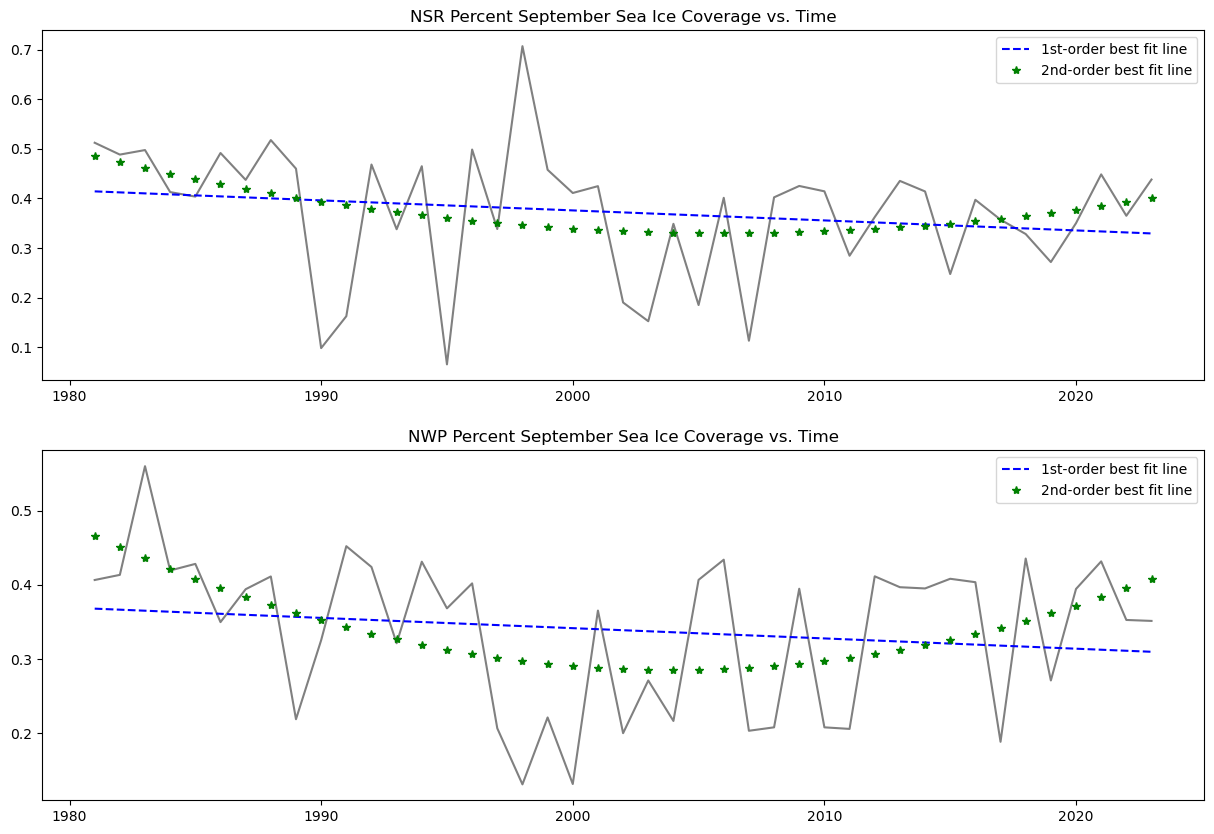

In [21]:
fig, ax = plt.subplots(2,1,figsize=(15,10))

ax[0].plot(years, nsr_perc_cover, '-', color='gray')
ax[0].plot(years, nsr_trendline1(years), '--', color='blue', label='1st-order best fit line')
ax[0].plot(years, nsr_trendline2(years), '*', color='green', label='2nd-order best fit line')
ax[0].set_title('NSR Percent September Sea Ice Coverage vs. Time')
ax[0].legend()

ax[1].plot(years, nwp_perc_cover, '-', color='gray')
ax[1].plot(years, nwp_trendline1(years), '--', color='blue', label='1st-order best fit line')
ax[1].plot(years, nwp_trendline2(years), '*', color='green', label='2nd-order best fit line')
ax[1].set_title('NWP Percent September Sea Ice Coverage vs. Time')
ax[1].legend()

Add Trouble Spot Percent Cover values to percent coverage csv so all data is in the same place

In [18]:
perc_cover = pd.read_csv('perc_coverage_data.csv')
perc_cover['nsr'] = nsr_perc_cover
perc_cover['nwp'] = nwp_perc_cover

perc_cover = perc_cover.set_index('year')
perc_cover.head()

,mo,arctic,nsr,nwp
year,,,,
1981,9,0.315789,0.512421,0.406556
1982,9,0.315078,0.488527,0.413474
1983,9,0.334282,0.497676,0.559853
1984,9,0.292319,0.412902,0.419400
1985,9,0.300853,0.403827,0.428258


In [19]:
perc_cover.to_csv('perc_coverage_data.csv')